# SMAI, Spring 2022
## Project: LeNet Implementation w/o AutoGrad

In [3]:
%pylab inline
import mnist

Populating the interactive namespace from numpy and matplotlib


#### The structure of LeNet
<!-- ![LeNet](Images/Lenet_struct.png "Structure of LeNet compared to AlexNet") -->
<img src="Images/Lenet_struct.png" width="400" height="300">

The plan is to implement a main `layer` class that deals with building different layers of the given neural network. This class will use text input to build different types of layers.  

In [4]:
# class utils():
#     def padder(data,pad_length):
#         im = data.copy()
#         m = im.shape[0]
#         n = im.shape[1]
#         M, N = m + 2*pad_length, n + 2*pad_length 
#         im2 = zeros((M,N))
#         im2[pad_length:m+pad_length , pad_length:n+pad_length] = im[:,:]
        
#         return im2
    
#     def Conv2D(data,kernel,stride =1):
        
#         kernel_size = np.array(np.array(kernel).shape)
#         im_size = np.array(np.array(im).shape)

#         final_dim = (im_size - kernel_size)/(stride) + np.array([1,1])
#         final_im = np.zeros(tuple(final_dim))

#         for i in range(final_dim[0]):
#             for j in range(final_dim[1]):
#                 final_im[i][j]= np.sum(np.multiply(im[i:i+kernel_size[0],j:j+kernel_size[1]],kernel))
#         return final_im

#     def AvgPool(self,data,kern_size,stride):
#         kern = np.ones(kern_size)/(kern_size)
#         return self.Conv2D(data,kern,stride)

#     def softmax(x):
#         denom = np.sum(np.exp(x))
#         y = x/denom;
#         return y

#     def sigmoid(x):
#         return 1/(1+np.exp(-x))

#     def Tanh(x):
#         a = 1.7159 
#         s = 2/3
#         return a*np.tanh(s*x)
    
#     def ReLU(x):
#         return np.max(x,0)
    
#     def normal(self, data):
#         padded = self.padder(data,2)
    
#     def vanilla(data,weights,bias, activation = 'Tanh'):
#         if activation == 'Tanh':
#             return utils.Tanh(np.dot(weights,data) + bias)
#         elif activation == 'sigmoid'
#             return  utils.sigmoid(np.dot(weights,data) + bias)

class utils():
    def padder(self, data, pad_length):
        im = data.copy()
        m = im.shape[0]
        n = im.shape[1]
        M, N = m + 2*pad_length, n + 2*pad_length 
        im2 = np.zeros((M,N))
        im2[pad_length:m+pad_length , pad_length:n+pad_length] = im[:,:]
        
        return im2
    
    def Conv2D(self, inputs, weights, bias, padding, K, F, stride =1):
        C, W, H = inputs.shape
        WW = (W - K)//stride + 1
        HH = (H - K)//stride + 1

        feature_maps = np.zeros((F, WW, HH))

        for f in range(F):
            for w in range(WW):
                for h in range(HH):
                    # ic(f, w, h, K, weights[f, :, :, :].shape, bias[f].shape, inputs[:, w:w+K, h:h+K].shape)
                    wi = w * stride
                    wj = wi + K 
                    hi = h * stride
                    hj = hi + K 
                    feature_maps[f,wi,hi]=np.sum(inputs[:,wi:wj,hi:hj]*weights[f,:,:,:])+bias[f]

        return feature_maps

    def AvgPool(self, data, pool_size, stride):
        C, W, H = data.shape

        new_width = (W - pool_size)//stride + 1
        new_height = (H - pool_size)//stride + 1

        out = np.zeros((C, new_width, new_height))

        for c in range(C):
            for w in range(new_width):
                for h in range(new_height):
                    out[c, w, h] = np.mean(data[c, w*stride:w*stride+pool_size, h*stride:h*stride+pool_size])
  
        return out

    def softmax(self, x):
        denom = np.sum(np.exp(x))
        y = np.exp(x)/denom;
        return y

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def Tanh(self, x):
        a = 1.7159 
        s = 2/3
        return a*np.tanh(s*x)

    def backTanh(self, x):
        a = 1.7159 
        s = 2/3
        return a*s*(1-np.tanh(s*x)**2)
    
    def ReLU(self, x):
        return np.max(x,0)
    
    def normal(self, data):
        padded = self.padder(data,2)
    
    def vanilla(self, data, weights, bias, activation = 'Tanh'):
        if activation == 'Tanh':
            # ic(np.transpose(weights).shape, data[:,0].shape)
            # ic(data)
            return self.Tanh(np.dot(np.transpose(weights),data) + bias)
        elif activation == 'sigmoid':
            return  self.sigmoid(np.dot(np.transpose(weights),data) + bias)

## Class of layers

In [5]:
util = utils()
class Layers():
    class CONV():
        def __init__(self, inputs_channel, num_filters, kernel_size):
          self.F = num_filters
          self.K = kernel_size
          self.C = inputs_channel

          self.weights = 2*(np.random.rand(self.F,self.C, self.K, self.K)-0.5)
          self.bias = 2*(np.random.rand(self.F, 1)-0.5)

        def forward(self, inputs, padding, stride):
            C = inputs.shape[0]
            W = inputs.shape[1]+2*padding
            H = inputs.shape[2]+2*padding

            self.inputs = np.zeros((C, W, H))

            for c in range(inputs.shape[0]):
                self.inputs[c,:,:] = util.padder(inputs[c,:,:], padding)

            return util.Conv2D(self.inputs, self.weights, self.bias, padding, self.K, self.F, stride)
          
        def backward(self, dy, stride, learning_rate):
            dy = util.backTanh(dy)

            C, W, H = self.inputs.shape

            dx = np.zeros(self.inputs.shape)
            dw = np.zeros(self.weights.shape)
            db = np.zeros(self.bias.shape)

            if len(dy.shape)==2:
              dy = np.array([dy])
            F, W, H = dy.shape

            for f in range(F):
                for w in range(0, W-self.K, stride):
                    for h in range(0, H-self.K, stride):
                        dw[f,:,:,:]+=dy[f,w,h]*self.inputs[:,w:w+self.K,h:h+self.K]
                        dx[:,w:w+self.K,h:h+self.K]+=dy[f,w,h]*self.weights[f,:,:,:]

            for f in range(F):
                db[f] = np.sum(dy[f, :, :])

            self.weights -= learning_rate * dw
            self.bias -= learning_rate * db

            return dx
    
    class POOL():
        def __init__(self, pool_size):
            self.pool = pool_size
        
        def forward(self, data, stride):
            self.inputs = data
            return util.AvgPool(data,self.pool,stride)
        # change later
        def backward(self, dy):
            C, W, H = self.inputs.shape
            dx = np.zeros(self.inputs.shape)
            
            for c in range(C):
                for w in range(0, W, self.pool):
                    for h in range(0, H, self.pool):
                        st = np.argmax(self.inputs[c,w:w+self.pool,h:h+self.pool])
                        (idx, idy) = np.unravel_index(st, (self.pool, self.pool))
                        dx[c, w+idx, h+idy] = dy[c, w//self.pool, h//self.pool]
            return dx
    
    class DENSE():
        def __init__(self, num_inputs, num_outputs, act):
            self.weights = 2*(np.random.rand(num_inputs, num_outputs)-0.5)
            self.bias = 2*(np.random.rand(num_outputs, 1)-0.5)
            self.act=act
        
        def forward(self, data):
            self.inputs = data
            if self.act == 'tanh':
              return util.Tanh(util.vanilla(data,self.weights,self.bias))
            elif self.act == 'softmax':
              self.out = util.softmax(util.vanilla(data,self.weights,self.bias)[:,0])
              return self.out

        def backward(self, dy, learning_rate):
            # print("blah",dy.shape)
            if self.act == 'tanh':
                dy = util.backTanh(dy).T
                dw = dy.dot(self.inputs.T)
                db = np.sum(dy, axis=1, keepdims=True)
                dx = np.dot(dy.T, self.weights.T)
            elif self.act=='softmax':
                # print("bleh",(self.out.T - dy.reshape(dy.shape[0],1)).shape)
                # print(self.out.T)
                # print(dy.reshape(dy.shape[0],1))
                # print(self.out.T - dy.reshape(dy.shape[0],1))
                # dy = self.out.T - dy.reshape(dy.shape[0],1)
                dy = self.out.T.reshape(dy.shape[0],1) - dy.reshape(dy.shape[0],1)
                dw = dy.dot(self.inputs.T)
                db = np.sum(dy, axis=1, keepdims=True)
                dx = np.dot(dy.T, self.weights.T)

            # print("blah",dy.shape)
            # if dy.shape[0] == self.inputs.shape[0]:
            #     dy = dy.T
            # print("blah",dy.shape)
            # dw = dy.dot(self.inputs)
            # db = np.sum(dy, axis=1, keepdims=True)
            # dx = np.dot(dy.T, self.weights.T)

            self.weights -= learning_rate * dw.T
            self.bias -= learning_rate * db

            return dx

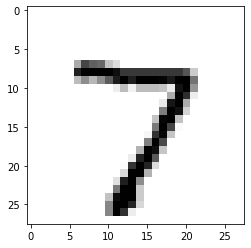

In [6]:
t = (mnist.test_images())
imshow(255- t[0], cmap='gray')

In [7]:
def Avg_k_sq(im,k):
    m = int((k-1)/2)
    
    M = im.shape[0]
    N = im.shape[1]     

    Paddy = zeros(( M + 2*m, N + 2*m))
   
    Paddy[m:M+m,m:N+m] = im[:,:]

    im2 = im.copy()
    filt = (1/(k*k))*ones((k,k))

    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            im2[i][j] = round(sum(Paddy[i:i+k,j:j+k]*filt))
            
    return im2

In [8]:
A = Layers.CONV(1,1,5)
imshow(A.forward())

TypeError: __init__() missing 3 required positional arguments: 'inputs_channel', 'num_filters', and 'kernel_size'